In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Set directories
train_dir = '/content/drive/MyDrive/Chest_XRay_Data/train'
val_dir = '/content/drive/MyDrive/Chest_XRay_Data/val'
test_dir = '/content/drive/MyDrive/Chest_XRay_Data/test'

In [13]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,        # Random rotations
    width_shift_range=0.2,    # Horizontal shifts
    height_shift_range=0.2,   # Vertical shifts
    shear_range=0.2,          # Shear transformations
    brightness_range=[0.5, 1.5]  # Random brightness adjustment
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=64,
                                               class_mode='binary')
val_data = test_datagen.flow_from_directory(val_dir,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary',
                                             shuffle=False)

Found 5217 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [15]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
# Train
history = model.fit(train_data,
                    epochs=5,
                    validation_data=val_data)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.7945 - loss: 0.4386 - val_accuracy: 0.8750 - val_loss: 0.3241
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9093 - loss: 0.2273 - val_accuracy: 0.8750 - val_loss: 0.2900
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9176 - loss: 0.2039 - val_accuracy: 0.8750 - val_loss: 0.2757
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9178 - loss: 0.2026 - val_accuracy: 0.8750 - val_loss: 0.2761
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9246 - loss: 0.1852 - val_accuracy: 0.8125 - val_loss: 0.3429


In [18]:
# Evaluate
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - accuracy: 0.9172 - loss: 0.2128
Test Accuracy: 84.62%


In [19]:
# Classification Report
predictions = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(test_data.classes, predictions, target_names=["NORMAL", "PNEUMONIA"]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step
              precision    recall  f1-score   support

      NORMAL       0.72      0.97      0.83       234
   PNEUMONIA       0.98      0.77      0.86       390

    accuracy                           0.85       624
   macro avg       0.85      0.87      0.84       624
weighted avg       0.88      0.85      0.85       624



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Image 1 is classified as: Normal
Image 2 is classified as: Normal
Image 3 is classified as: Normal
Image 4 is classified as: Normal
Image 5 is classified as: Normal
Image 6 is classified as: Normal
Image 7 is classified as: Normal
Image 8 is classified as: Normal
Image 9 is classified as: Normal
Image 10 is classified as: Normal
Image 11 is classified as: Normal
Image 12 is classified as: Normal
Image 13 is classified as: Normal
Image 14 is classified as: Normal
Image 15 is classified as: Normal
Image 16 is classified as: Normal


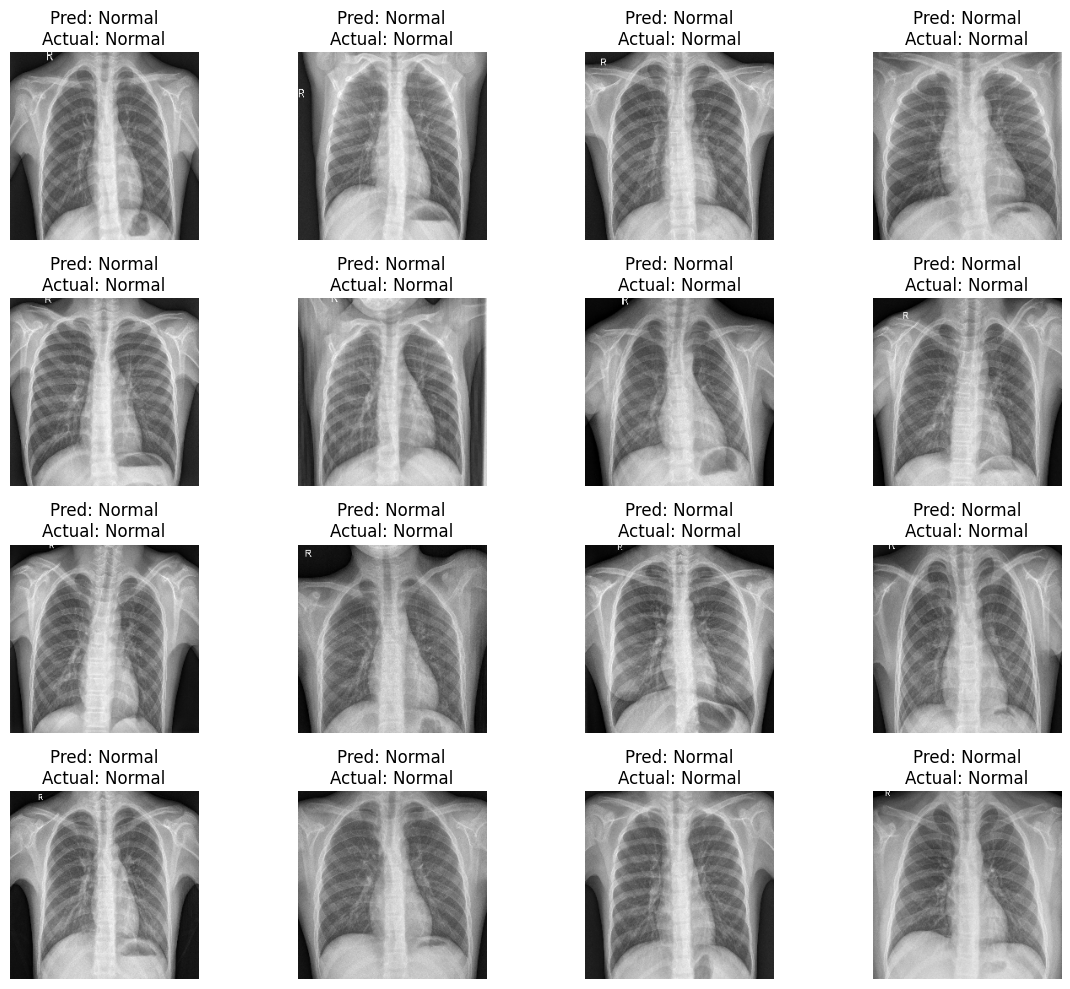

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Get one batch from the test generator
x_batch, y_batch = next(test_data)  # (images, true_labels)

# Select the first 16 images and labels from the batch
x_batch_16 = x_batch[:16]
y_batch_16 = y_batch[:16]

# Make predictions
predictions = model.predict(x_batch_16)

# Convert sigmoid output to class labels
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Print predictions
for i, pred_class in enumerate(predicted_classes):
    print(f"Image {i+1} is classified as: {'Normal' if pred_class == 0 else 'Pneumonia'}")

# Convert true labels to class labels
true_classes = y_batch_16.flatten()
true_class_labels = ['Normal' if label == 0 else 'Pneumonia' for label in true_classes]

# Display images with predictions and actual labels in a 4x4 grid
plt.figure(figsize=(12, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_batch_16[i])
    plt.title(f"Pred: {'Normal' if predicted_classes[i] == 0 else 'Pneumonia'}\nActual: {'Normal' if true_class_labels[i] == 'Normal' else 'Pneumonia'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step


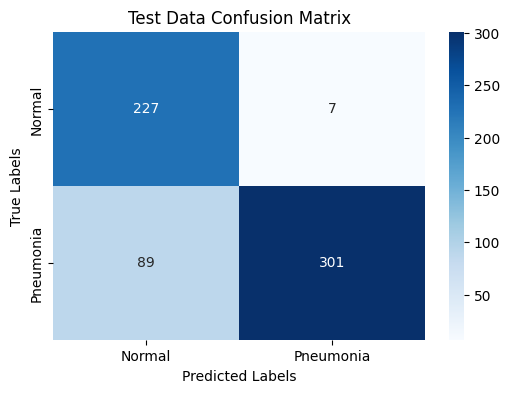

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# --- Test Data Confusion Matrix ---
test_preds = (model.predict(test_data) > 0.5).astype("int32").flatten()
plot_confusion_matrix(test_data.classes, test_preds, title='Test Data Confusion Matrix')